In [1]:
import numpy as np
import matplotlib.pyplot as plt
import hera_sim
import uvtools
from astropy import constants, units
%matplotlib inline

The point of this notebook is to show how to use the `MutualCoupling` class and build some intuition for how array geometry affects how the mutual coupling manifests.

In [2]:
data_config = dict(
    Nfreqs=300,
    start_freq=140e6,
    channel_width=100e3,
    Ntimes=300,
    start_time=2458091.2234,
    integration_time=10.7,
#     telescope_location=np.zeros(3),
    telescope_location=hera_sim.io.HERA_LAT_LON_ALT,
)

In [3]:
sep = 30
n_rows = 4
n_cols = 4
base_array = {}
antnum = 0
for row in range(n_rows):
    y_pos = row * sep
    for col in range(n_cols):
        x_pos = col * sep
        base_array[antnum] = np.array([x_pos,y_pos,0])
        antnum += 1

In [4]:
uvdata = hera_sim.io.empty_uvdata(array_layout=base_array, **data_config)

Cannot check consistency of a string-mode BeamList! Set force=True to force consistency checking.
Fixing phases using antenna positions.


In [3]:
def mock_visibility(uvdata, delay_width=200e-9, ref_freq=150e6):
    freqs = uvdata.freq_array.squeeze()
    times = np.unique(uvdata.time_array) * units.day.to("s")
    freq_mesh, time_mesh = np.meshgrid(freqs, times-times.mean())
    omega0 = units.cycle.to("rad") / units.sday.to("s")
    omega = np.array([0,0,omega0])
    enu_antpos = uvdata.get_ENU_antpos()[0]
    ecef_antpos = uvdata.antenna_positions
    antenna_numbers = uvdata.antenna_numbers
    zenith = uvdata.telescope_location / np.linalg.norm(uvdata.telescope_location)
    
    for ai, aj in uvdata.get_antpairs():
        if uvdata.antpair2ind(ai,aj).size == 0: continue
        i = antenna_numbers.tolist().index(ai)
        j = antenna_numbers.tolist().index(aj)
        ecef_bl = ecef_antpos[j] - ecef_antpos[i]
        enu_bl = enu_antpos[j] - enu_antpos[i]
        dbdt = np.cross(ecef_bl, omega)
        b = np.linalg.norm(ecef_bl)
        sign = np.sign(np.round(enu_bl[0],3))
        frates = sign * freq_mesh * np.linalg.norm(dbdt) / constants.c.si.value
        blt_inds = uvdata.antpair2ind(ai,aj)
        uvdata.data_array[blt_inds,0,:,0] = np.exp(
            -(delay_width * (freq_mesh-ref_freq))**2
        ) * np.exp(
            2j * np.pi * frates[None,:] * time_mesh
        )

In [6]:
mock_visibility(uvdata, delay_width=50e-9, ref_freq=uvdata.freq_array.mean())

In [7]:
sim = hera_sim.Simulator(data=uvdata)

In [8]:
xt_kwargs = dict(
    uvbeam="uniform",
    reflection=np.ones(sim.Nfreqs) * 1e0,
    resistance=np.ones(sim.Nfreqs) * 57,
)

In [9]:
sim.add("mutual_coupling", **xt_kwargs)

You have not specified how to seed the random state. This effect might not be exactly recoverable.


In [262]:
mutual_coupling = hera_sim.sigchain.MutualCoupling(
    uvbeam="uniform",
    ant_1_array=uvdata.ant_1_array,
    ant_2_array=uvdata.ant_2_array,
    pol_array=uvdata.polarization_array,
    array_layout=dict(zip(*uvdata.get_ENU_antpos()[::-1])),
    reflection=np.ones(uvdata.Nfreqs) * 1e0,
    resistance=np.ones(uvdata.Nfreqs) * 57,
)

In [230]:
coupling = mutual_coupling.build_coupling_matrix(
    freqs=uvdata.freq_array.squeeze() / 1e9,
    ant_1_array=uvdata.ant_1_array,
    ant_2_array=uvdata.ant_2_array,
    array_layout=dict(zip(*uvdata.get_ENU_antpos()[::-1])),
    uvbeam="uniform",
)

In [263]:
uvdata.data_array += mutual_coupling(uvdata.freq_array.squeeze()/1e9, uvdata.data_array)

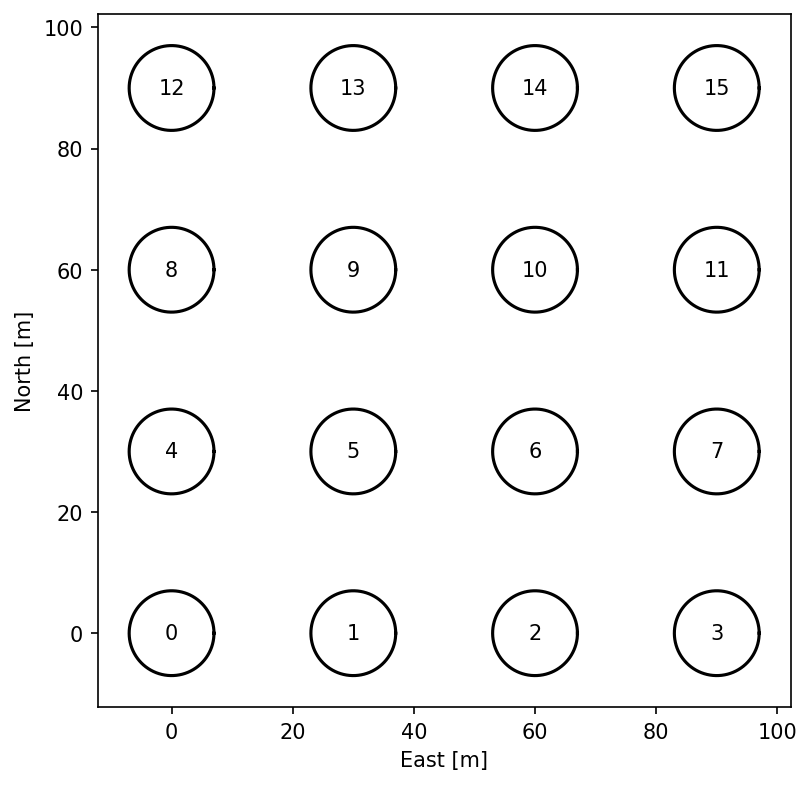

In [264]:
enu_antpos = dict(zip(*uvdata.get_ENU_antpos()[::-1]))
fig, ax = plt.subplots(1,1,figsize=(6,6),dpi=150)
ax.set_xlabel("East [m]")
ax.set_ylabel("North [m]")
dish = 7 * np.exp(2j * np.linspace(0,np.pi,360))
for ant, (e,n,u) in enu_antpos.items():
    ax.plot(e+dish.real, n+dish.imag, color='k')
    ax.text(e,n,ant,ha='center',va='center')
ax.set_aspect("equal")

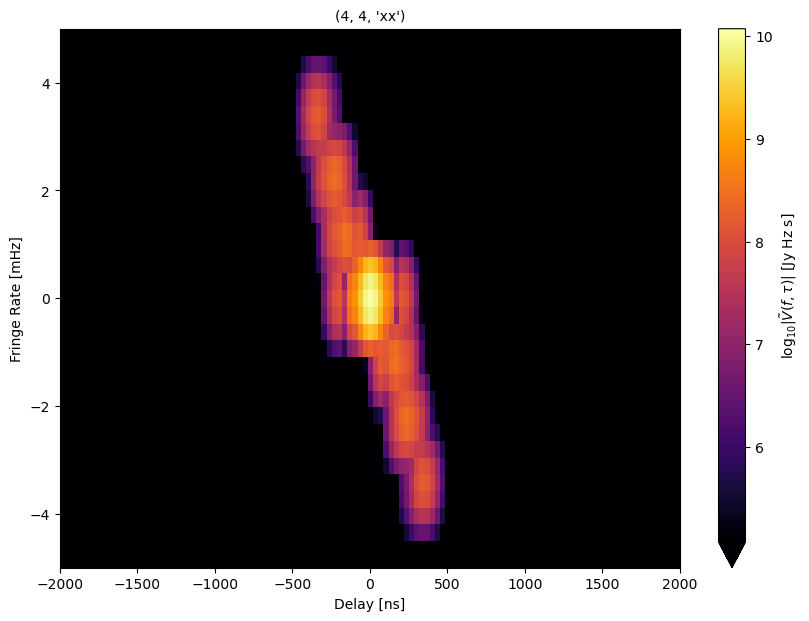

In [13]:
fig, ax = uvtools.plot.labeled_waterfall(
    sim.data, (4,4,'xx'), fft_axis="both", freq_taper="bh", time_taper="bh", dynamic_range=5,
    
)
ax.set_xlim(-2000, 2000)
ax.set_ylim(-5,5);

In [253]:
array_layout = base_array.copy()
array_layout[99] = np.array([-100,200,0])

In [254]:
uvdata = hera_sim.io.empty_uvdata(array_layout=array_layout, **data_config)

Cannot check consistency of a string-mode BeamList! Set force=True to force consistency checking.
Fixing phases using antenna positions.


In [255]:
mock_visibility(uvdata, delay_width=50e-9, ref_freq=uvdata.freq_array.mean())

In [256]:
mutual_coupling = hera_sim.sigchain.MutualCoupling(
    uvbeam="uniform",
    ant_1_array=uvdata.ant_1_array,
    ant_2_array=uvdata.ant_2_array,
    pol_array=uvdata.polarization_array,
    array_layout=dict(zip(*uvdata.get_ENU_antpos()[::-1])),
    reflection=np.ones(uvdata.Nfreqs) * 1e0,
    resistance=np.ones(uvdata.Nfreqs) * 57,
)

In [257]:
uvdata.data_array += mutual_coupling(uvdata.freq_array.squeeze()/1e9, uvdata.data_array)

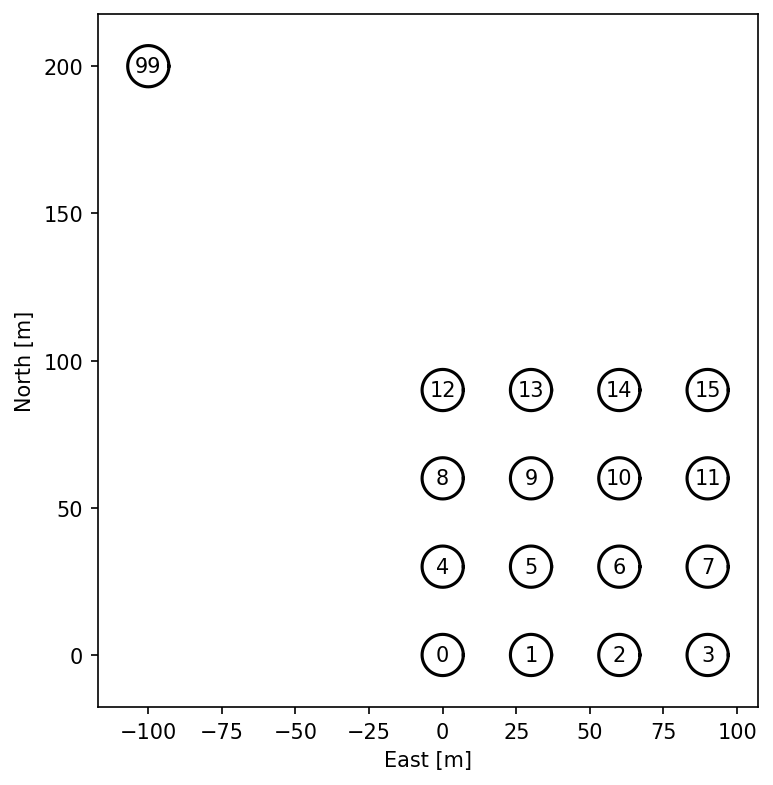

In [258]:
enu_antpos = dict(zip(*uvdata.get_ENU_antpos()[::-1]))
fig, ax = plt.subplots(1,1,figsize=(6,6),dpi=150)
ax.set_xlabel("East [m]")
ax.set_ylabel("North [m]")
dish = 7 * np.exp(2j * np.linspace(0,np.pi,360))
for ant, (e,n,u) in enu_antpos.items():
    ax.plot(e+dish.real, n+dish.imag, color='k')
    ax.text(e,n,ant,ha='center',va='center')
ax.set_aspect("equal")

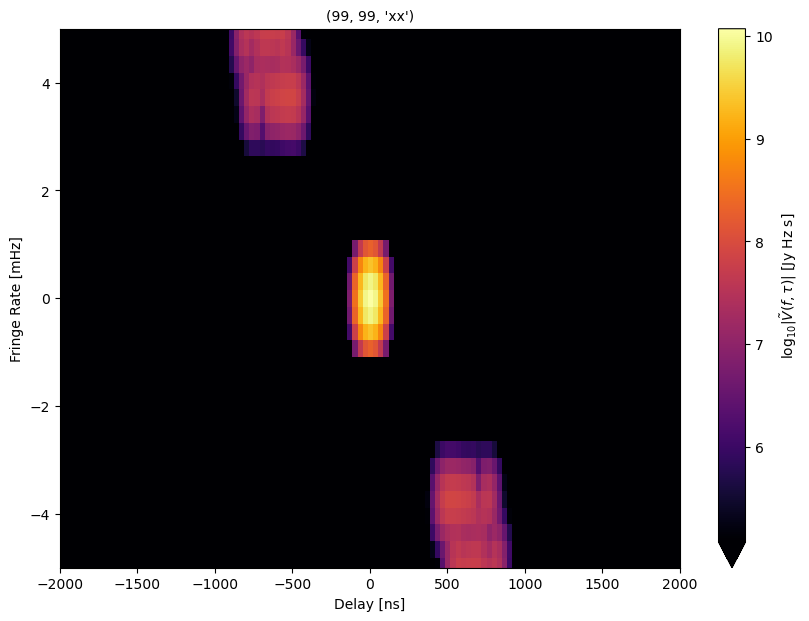

In [259]:
fig, ax = uvtools.plot.labeled_waterfall(
    uvdata, (99,99,'xx'), fft_axis="both", freq_taper="bh", time_taper="bh", dynamic_range=5,
    
)
ax.set_xlim(-2000, 2000)
ax.set_ylim(-5,5);